In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from osprey.actions.reader import reader_nemo, reader_nemo_field
from osprey.means.means import elements

In [2]:
data = reader_nemo_field(expname='FE06', startyear=1990, endyear=2006, varname='thetao')
#df = elements('ORCA2')
#ave = data['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
#ave_result= ave.compute()

2024-10-29 11:40:27,533 - INFO - Data available in the range 1990-2006.


In [6]:
df = elements('ORCA2')

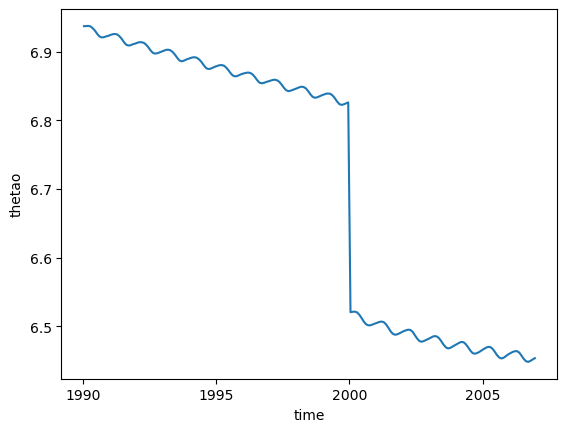

In [8]:
data.weighted(df['V']).mean(dim=['x','y','z']).plot()

In [8]:
data['time']

<xarray.DataArray 'time' (time: 12)> Size: 96B
array([cftime.DatetimeGregorian(2349, 1, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 2, 15, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 3, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 4, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 5, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 6, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 7, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 8, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 9, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 10, 16, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2349, 12, 16, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 96B 2349-01-16 12:00:00 ... 2349-12-16 12:00:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1900-01-01 00:00:00
    bounds:         time_counter_bounds

In [2]:
wdata = reader_nemo(expname='lgr3', startyear=2349, endyear=2349, grid='W')

2024-10-27 16:58:55,065 - INFO - Data available in the range 2349-2349.


In [3]:
data['tos']

<xarray.DataArray 'tos' (time: 12, y: 148, x: 180)> Size: 1MB
dask.array<open_dataset-tos, shape=(12, 148, 180), dtype=float32, chunksize=(12, 148, 180), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lon      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
  * time     (time) object 96B 2349-01-16 12:00:00 ... 2349-12-16 12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       bulk_sea_surface_temperature
    long_name:           Bulk sea surface temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)

In [4]:
from osprey.actions.reader import reader_rebuilt

rdata = reader_rebuilt('FE02', 101, 101)
rdata = rdata.rename({'time_counter': 'time', 'nav_lev': 'z'})
rdata

2024-10-24 13:03:37,474 - INFO -  File to be loaded ['/ec/res4/scratch/itas/martini/FE02/101/FE02_00584400_restart.nc']


<xarray.Dataset> Size: 96MB
Dimensions:      (y: 148, x: 180, z: 31, time: 1)
Coordinates:
  * z            (z) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
  * time         (time) float32 4B 5.844e+05
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon      (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    nav_lat      (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    kt           float64 8B ...
    ndastp       float64 8B ...
    adatrj       float64 8B ...
    ntime        float64 8B ...
    ...           ...
    sshn         (time, y, x) float64 213kB dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
    un           (time, z, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    vn           (time, z, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    tn           (time, z, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    sn           (time, z, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    rhop         (time, z, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
Attributes:
    file_name:  /ec/res4/scratch/itas/martini/FE02/101/FE02_00584400_restart.nc
    TimeStamp:  02/10/2024 13:01:18 -0000

In [3]:
rdata['z'] = -rdata['z']
theta = rdata['tn'].isel(time=0)
theta = theta.drop_vars(['time'], errors='ignore')
dz = rdata['z'].diff(dim='z')
grad = theta.diff(dim='z') / dz

In [4]:
from osprey.actions.reader import read_domain
domain = read_domain('ORCA2')
domain['z'] = -domain['z']

In [5]:
df = elements('ORCA2')
proftheta = theta.weighted(df['S']).mean(dim=['y', 'x'])
profgrad = grad.weighted(df['S']).mean(dim=['y', 'x'])

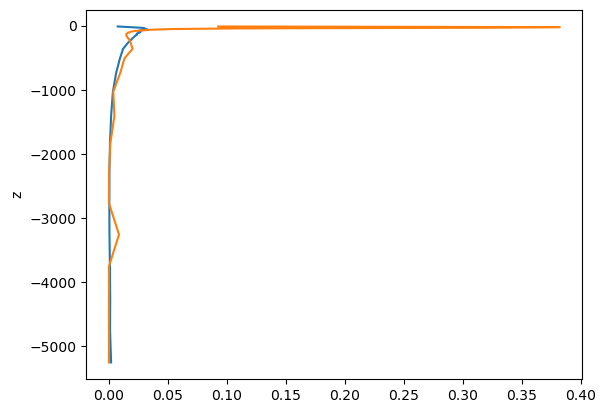

In [7]:
#proftheta.plot(y='z')
profgrad.plot(y='z')
grad.isel(x=100,y=80).plot(y='z')

In [1]:
import gsw  # Gibbs SeaWater library for oceanographic calculations

def density(thetao, so):
    """ Potential density """

    pressure = gsw.p_from_z(-thetao['z'], thetao['lat'])
    rho = gsw.density.rho(so, thetao, pressure)

    return rho

In [7]:
data = reader_nemo(expname='lfr0', startyear=2000, endyear=2000)
#rdata = reader_rebuilt('FE02', 101, 101)
#rdata = rdata.rename({'time_counter': 'time', 'nav_lev': 'z'})
rho = density(data['thetao'],data['so'])
rho  = rho.isel(time=-1)
rho = rho.drop_vars(['time'], errors='ignore')
dz = data['z'].diff(dim='z')
rhograd = rho.diff(dim='z') / dz

2024-10-24 13:13:50,990 - INFO - Data available in the range 2000-2000.


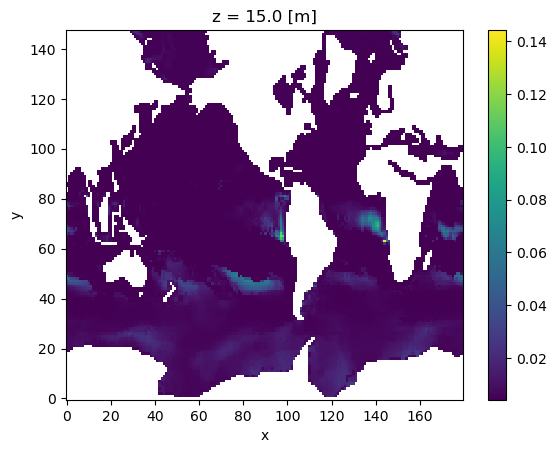

In [8]:
rhograd.isel(z=0).plot()

In [9]:
unstable_zones = {}
unstable_zones = xr.where(rhograd > 0, 1.0, 0.0)

In [10]:
sumzones = unstable_zones.sum(dim='z')

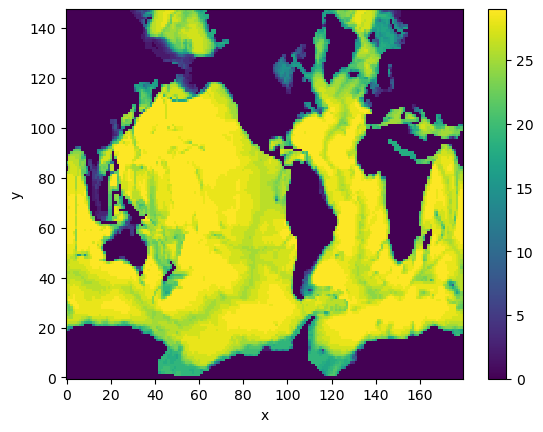

In [11]:
sumzones.plot()

In [15]:
from osprey.utils.vardict import vardict
from osprey.actions.reader import reader_nemo

info = vardict('nemo')['keos']
gridlist = info['grid']
varlist = info['dependencies']

field = {}
for grid, var in zip(gridlist, varlist):
    data = reader_nemo(expname='lfr0', startyear=1990, endyear=2010, grid=grid)
    field[grid] = data[var]

2024-10-10 13:56:48,470 - INFO - Data available in the range 1990-2010.
2024-10-10 13:56:52,398 - INFO - Data available in the range 1990-2010.


In [1]:
from osprey.utils.vardict import vardict
from osprey.actions.reader import reader_nemo

expname='lfr0'
startyear=1990
endyear=2000
varname='keos'

info = vardict('nemo')[varname]

if 'dependencies' in info: 
    field = {}
    for grid, var in zip(info['grid'], info['dependencies']):
        data = reader_nemo(expname=expname, startyear=startyear, endyear=endyear, grid=grid)
        field[var] = data[var]
        if 'preprocessing' in info:
            field[var] = info['preprocessing'][var](field[var])
    data = info['operation'](*[field[var] for var in info['dependencies']])
else:
    data = reader_nemo(expname=expname, startyear=startyear, endyear=endyear, grid=info['grid'])
    data = data[varname]
data

2024-10-14 14:19:35,691 - INFO - Data available in the range 1990-2000.
2024-10-14 14:19:57,042 - INFO - Data available in the range 1990-2000.


<xarray.DataArray (time: 132, y: 148, x: 180)> Size: 14MB
dask.array<mul, shape=(132, 148, 180), dtype=float32, chunksize=(12, 148, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1kB 1990-01-16 12:00:00 ... 2000-12-16 12:00:00
  * x        (x) float64 1kB 0.5 1.5 2.5 3.5 4.5 ... 176.5 177.5 178.5 179.5
  * y        (y) int64 1kB 0 1 2 3 4 5 6 7 8 ... 140 141 142 143 144 145 146 147

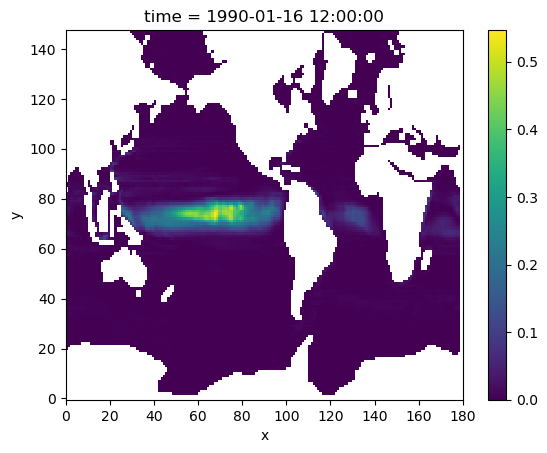

In [2]:
data.isel(time=0).plot()

```
import numpy as np
import xarray as xr
import logging
from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from dask.distributed import LocalCluster, Client, progress
from dask.distributed.diagnostics import MemorySampler

data = reader_nemo(expname='lfr0', startyear=1990, endyear=2010)

cluster = LocalCluster(n_workers=2, threads_per_worker=1, memory_limit='8GB')
client = Client(cluster)
df = elements('ORCA2')
ave = data['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
ms = MemorySampler()
with ms.sample('chunk'):
    ave_result= ave.compute()
array_data = np.array(vars(ms)['samples']['chunk'])
avg_mem = np.mean(array_data[:, 1])/1e9
max_mem = np.max(array_data[:, 1])/1e9
client.shutdown()
cluster.close()
logging.warning('Avg memory used: %.2f GiB, Peak memory used: %.2f GiB', avg_mem, max_mem)
ave_result.plot()
```

2024-10-03 09:02:37,266 - INFO - Data available in the range 1990-2029.
2024-10-03 09:03:07,657 - INFO - Data available in the range 1990-2060.
/ec/res4/scratch/itas/tmp/ipykernel_3955647/2617636636.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


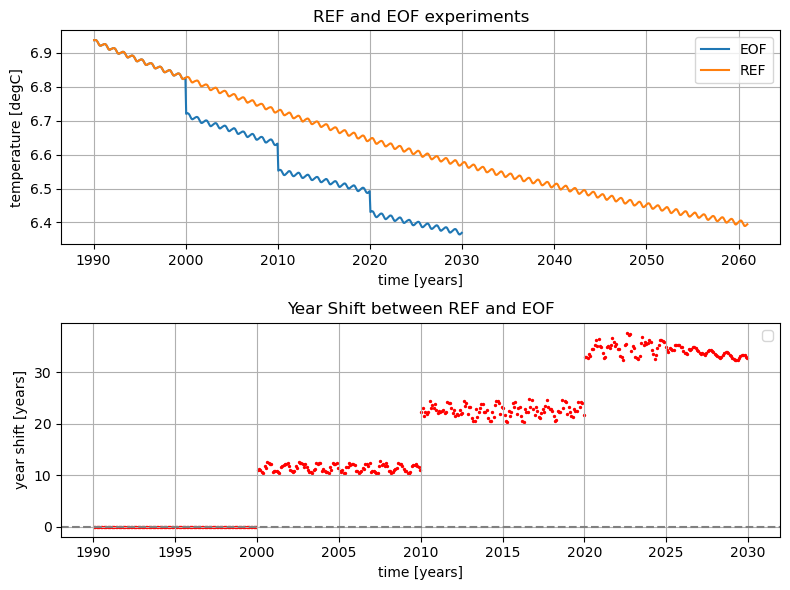

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from osprey.utils.time import get_decimal_year

# Function to calculate the horizontal shift between curve 1 and curve 2 relative to curve 1
def calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=20.0):
    # Interpolate curve 2 with respect to y-values to get x2 = f(y2)
    interp_curve2_inv = interp1d(y2, x2, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # List to store the horizontal shift for each point of curve 1
    shifts = []
    
    # Calculate the shift for each point in curve 1
    for i in range(len(x1)):
        y1_point = y1[i]  # y-value of curve 1
        x1_point = x1[i]  # x-value of curve 1

        # Find the corresponding x-value on curve 2 for the same y-value
        x2_point = interp_curve2_inv(y1_point)
        
        # Calculate the horizontal shift
        shift = x2_point - x1_point
        
        # Add a condition for the maximum acceptable shift threshold
        if abs(shift) > shift_threshold:
            shift = np.nan  # Ignore shifts that are too large (set to NaN)
        
        shifts.append(shift)
    
    return np.array(shifts)

# load data
df = elements('ORCA2')

data1 = reader_nemo(expname='FE01', startyear=1990, endyear=2029)
ave1 = data1['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y1 = ave1.compute()
x1 = get_decimal_year(data1['time'].values)

data2 = reader_nemo(expname='lfr0', startyear=1990, endyear=2060)
ave2 = data2['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y2 = ave2.compute()
x2 = get_decimal_year(data2['time'].values)

# Calculate the shift relative to curve 1 with a maximum shift threshold
shift = calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=50.)

# Create subplots: one for the curves and one for the horizontal shift
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the curves in the first subplot
ax1.plot(x1, y1, label='EOF')
ax1.plot(x2, y2, label='REF')
ax1.set_xlabel('time [years]')
ax1.set_ylabel('temperature [degC]')
ax1.set_title('REF and EOF experiments')
ax1.legend()
ax1.grid()

# Plot the horizontal shift in the second subplot
ax2.scatter(x1, shift, color='red', s=2)
ax2.axhline(0, color='gray', linestyle='--')  # Zero reference line
ax2.set_xlabel('time [years]')
ax2.set_ylabel('year shift [years]')
ax2.set_title('Year Shift between REF and EOF')
ax2.legend()
ax2.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

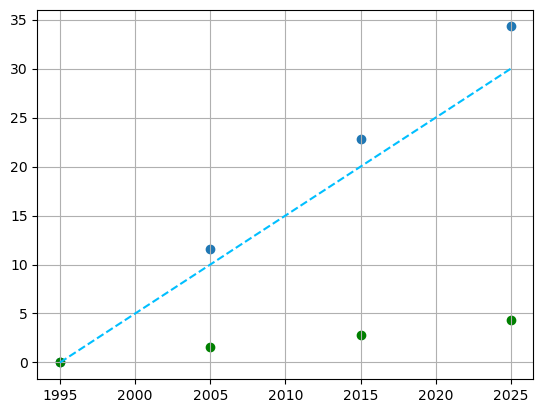

In [49]:
# Definire la dimensione di un gradino (10 anni = 120 mesi)
step_size = 121
# Suddividere l'array in intervalli di 120 mesi e calcolare la media per ciascun gradino
mean_values = [np.mean(shift[i:i + step_size]) for i in range(0, len(shift), step_size)]
mean_time = [int(np.mean(x1[i:i + step_size])) for i in range(0, len(x1), step_size)]
linear_curve = [mean_time[i]-1995 for i in range(0, len(mean_time))]
delta = [mean_values[i]-linear_curve[i] for i in range(0, len(mean_values))]
plt.scatter(mean_time, mean_values)
plt.plot(mean_time, linear_curve, color='deepskyblue', linestyle='--')
plt.scatter(mean_time, delta, color='green')
plt.grid()

2024-10-03 09:48:42,795 - INFO - Data available in the range 1990-2029.


2024-10-03 09:48:46,023 - INFO - Data available in the range 1990-2060.
/ec/res4/scratch/itas/tmp/ipykernel_3955647/3077123470.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


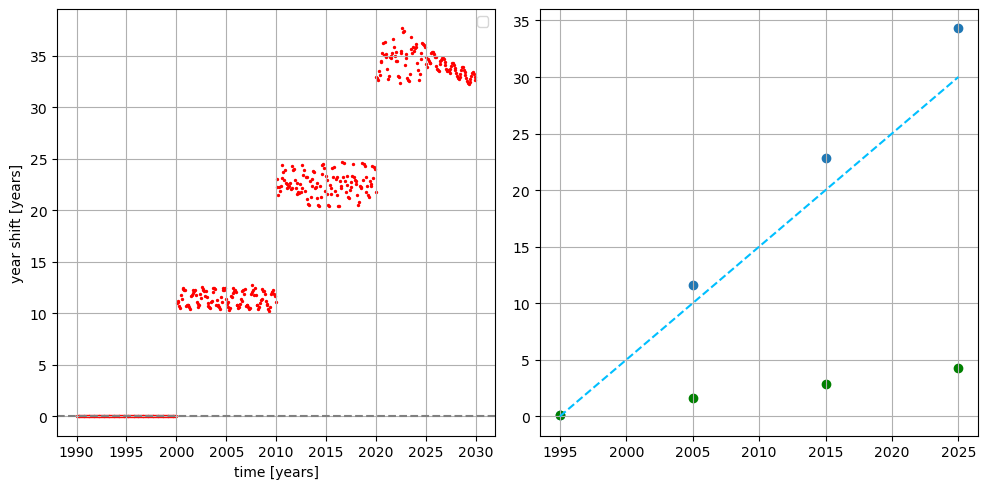

In [54]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from osprey.utils.time import get_decimal_year

# Function to calculate the horizontal shift between curve 1 and curve 2 relative to curve 1
def calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=20.0):
    # Interpolate curve 2 with respect to y-values to get x2 = f(y2)
    interp_curve2_inv = interp1d(y2, x2, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # List to store the horizontal shift for each point of curve 1
    shifts = []
    
    # Calculate the shift for each point in curve 1
    for i in range(len(x1)):
        y1_point = y1[i]  # y-value of curve 1
        x1_point = x1[i]  # x-value of curve 1

        # Find the corresponding x-value on curve 2 for the same y-value
        x2_point = interp_curve2_inv(y1_point)
        
        # Calculate the horizontal shift
        shift = x2_point - x1_point
        
        # Add a condition for the maximum acceptable shift threshold
        if abs(shift) > shift_threshold:
            shift = np.nan  # Ignore shifts that are too large (set to NaN)
        
        shifts.append(shift)
    
    return np.array(shifts)

# load data
df = elements('ORCA2')

data1 = reader_nemo(expname='FE01', startyear=1990, endyear=2029)
ave1 = data1['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y1 = ave1.compute()
x1 = get_decimal_year(data1['time'].values)

data2 = reader_nemo(expname='lfr0', startyear=1990, endyear=2060)
ave2 = data2['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y2 = ave2.compute()
x2 = get_decimal_year(data2['time'].values)

# Calculate the shift relative to curve 1 with a maximum shift threshold
shift = calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=50.)

# Create subplots: one for the curves and one for the horizontal shift
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the horizontal shift in the second subplot
ax1.scatter(x1, shift, color='red', s=2)
ax1.axhline(0, color='gray', linestyle='--')  # Zero reference line
ax1.set_xlabel('time [years]')
ax1.set_ylabel('year shift [years]')
ax1.legend()
ax1.grid()

# Definire la dimensione di un gradino (10 anni = 120 mesi)
step_size = 121
# Suddividere l'array in intervalli di 120 mesi e calcolare la media per ciascun gradino
mean_values = [np.mean(shift[i:i + step_size]) for i in range(0, len(shift), step_size)]
mean_time = [int(np.mean(x1[i:i + step_size])) for i in range(0, len(x1), step_size)]
linear_curve = [mean_time[i]-1995 for i in range(0, len(mean_time))]
delta = [mean_values[i]-linear_curve[i] for i in range(0, len(mean_values))]
ax2.scatter(mean_time, mean_values)
ax2.plot(mean_time, linear_curve, color='deepskyblue', linestyle='--')
ax2.scatter(mean_time, delta, color='green')
ax2.set_xlabel('time [years]')
ax2.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


2024-09-30 12:02:22,816 - INFO - Data available in the range 1990-2029.


2024-09-30 12:02:27,715 - INFO - Data available in the range 1990-2060.
/ec/res4/scratch/itas/tmp/ipykernel_2378677/1989777862.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


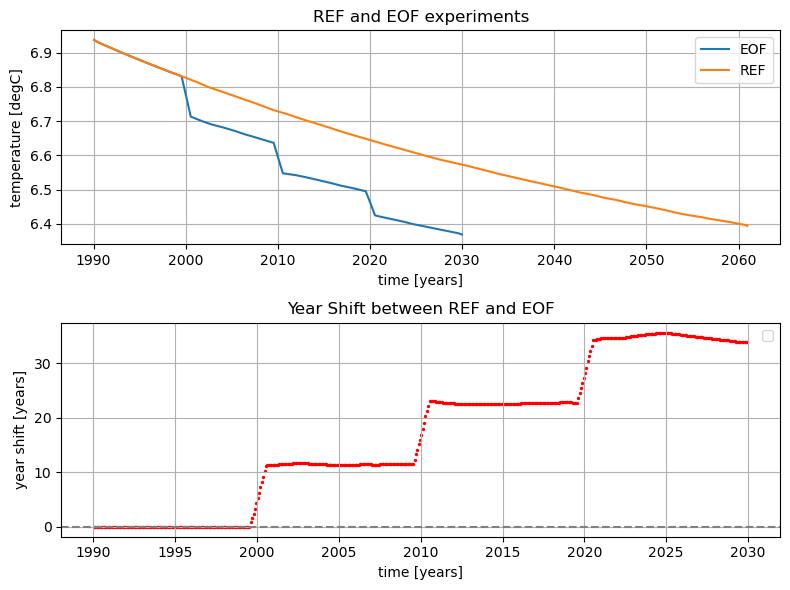

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from osprey.actions.reader import reader_nemo
from osprey.means.means import elements
from osprey.utils.time import get_decimal_year
from osprey.means.means import movave

# Function to calculate the horizontal shift between curve 1 and curve 2 relative to curve 1
def calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=20.0):
    # Interpolate curve 2 with respect to y-values to get x2 = f(y2)
    interp_curve2_inv = interp1d(y2, x2, kind='linear', bounds_error=False, fill_value="extrapolate")
    
    # List to store the horizontal shift for each point of curve 1
    shifts = []
    
    # Calculate the shift for each point in curve 1
    for i in range(len(x1)):
        y1_point = y1[i]  # y-value of curve 1
        x1_point = x1[i]  # x-value of curve 1

        # Find the corresponding x-value on curve 2 for the same y-value
        x2_point = interp_curve2_inv(y1_point)
        
        # Calculate the horizontal shift
        shift = x2_point - x1_point
        
        # Add a condition for the maximum acceptable shift threshold
        if abs(shift) > shift_threshold:
            shift = np.nan  # Ignore shifts that are too large (set to NaN)
        
        shifts.append(shift)
    
    return np.array(shifts)

# load data
df = elements('ORCA2')

data1 = reader_nemo(expname='FE01', startyear=1990, endyear=2029)
ave1 = data1['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y1 = movave(ave1,12)
#y1 = mave1.compute()
x1 = get_decimal_year(data1['time'].values)

data2 = reader_nemo(expname='lfr0', startyear=1990, endyear=2060)
ave2 = data2['thetao'].weighted(df['V']).mean(dim=['z', 'y', 'x'])
y2 = movave(ave2,12)
#y2 = mave2.compute()
x2 = get_decimal_year(data2['time'].values)

# Calculate the shift relative to curve 1 with a maximum shift threshold
shift = calculate_shift_curve1(x1, y1, x2, y2, shift_threshold=50.)

# Create subplots: one for the curves and one for the horizontal shift
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot the curves in the first subplot
ax1.plot(x1, y1, label='EOF')
ax1.plot(x2, y2, label='REF')
ax1.set_xlabel('time [years]')
ax1.set_ylabel('temperature [degC]')
ax1.set_title('REF and EOF experiments')
ax1.legend()
ax1.grid()

# Plot the horizontal shift in the second subplot
ax2.scatter(x1, shift, color='red', s=2)
ax2.axhline(0, color='gray', linestyle='--')  # Zero reference line
ax2.set_xlabel('time [years]')
ax2.set_ylabel('year shift [years]')
ax2.set_title('Year Shift between REF and EOF')
ax2.legend()
ax2.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()